In [1]:
import pickle
import numpy as np
import itertools
import random
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import re
import os
from scipy.interpolate import make_interp_spline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from collections import Counter
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier

In [2]:
pickle_filename = 'songs_dataset_train.pkl'
with open(pickle_filename, 'rb') as file:
    train_df = pickle.load(file)


pickle_filename = 'songs_dataset_test.pkl'
with open(pickle_filename, 'rb') as file:
    test_df = pickle.load(file)



num_train = train_df.drop(['Lyrics', 'Title', 'Raw_Lyrics'], axis=1)
num_test = test_df.drop(['Lyrics', 'Title', 'Raw_Lyrics'], axis=1)



artist_list_file = "artist_list.pkl"

# Load the 'artists' list from the saved file
with open(artist_list_file, 'rb') as file:
    artists = pickle.load(file)

arts_dict = {}
for i in range(len(artists)):
    arts_dict[artists[i]] = i
    
arts_dict_op = {i: artist for artist, i in arts_dict.items()}

arts_in_dataset = set(train_df['Artist'].values)

In [3]:
def n_sets_func(df, art_set):
    """
    Filter and preprocess a DataFrame based on a given artist set.

    Args:
        df (DataFrame): The input DataFrame containing artist-related data.
        art_set (list): A list of artists to filter the DataFrame.

    Returns:
        tuple: A tuple containing the following elements:
            - df2 (DataFrame): The filtered DataFrame with specified columns.
            - fts (Index): The column names of the filtered DataFrame.
            - pos_w (float): The positive weight for each artist set (1 - 1/n_art).
            - neg_w (float): The negative weight for each artist set (1/n_art).
    """
    df2 = df.drop(df.columns[[0, 3, 4]], axis=1)
    df2.reset_index(drop=True, inplace=True)
    df2 = df2[df2['Artist'].isin(art_set)]
    n_art = len(art_set)
    pos_w = (n_art - 1) / n_art
    neg_w = 1 / n_art
    fts = df2.columns
    
    return df2, fts, pos_w, neg_w


In [4]:
def mean_of_arrays(matrix):
    """
    Calculate the mean values along each column of a matrix.

    Args:
        matrix (numpy.ndarray): The input matrix for which to calculate means.

    Returns:
        list: A list of mean values for each column of the input matrix.
    """
    mean_values = np.mean(matrix, axis=0)
    return mean_values.tolist()

In [5]:
def artist_df(artist, df):
    """
    Calculate the mean and standard deviation of features for songs by a specific artist in a DataFrame.

    Args:
        artist : The identifier of the artist.
        df (DataFrame): The input DataFrame containing song data.

    Returns:
        tuple: A tuple containing the following elements:
            - artist_stats (DataFrame): A DataFrame with the average and standard deviation of features for the artist's songs.
            - mean_vector (numpy.ndarray): The mean TF-IDF vector of the artist's songs.
    """
    art_data = df[df['Artist'] == artist]
    arrays = art_data['TFIDF_Vector'].values
    matrix = np.stack(arrays)
    mean_vector = np.array(np.mean(matrix, axis=0))
    average_features_artist = art_data.mean(numeric_only=True)
    std_features_artist = art_data.std(numeric_only=True)
    artist_stats = pd.DataFrame({'Average': average_features_artist, 'Standard Deviation': std_features_artist})
    artist_stats = artist_stats.transpose().drop("Artist", axis=1)
    
    return artist_stats, mean_vector


In [6]:
def cosine_angle(vector1, vector2):
    """
    Calculate the cosine similarity between two vectors.

    Args:
        vector1 (numpy.ndarray): The first vector.
        vector2 (numpy.ndarray): The second vector.

    Returns:
        float: A similarity score between 0 and 1, where 1 indicates high similarity.
        
    Note:
        This function is typically used for calculating the cosine similarity
        between TF-IDF vectors or other vectors in the context of text analysis
        or recommendation systems.
    """
    dot_prod = np.dot(vector1, vector2)
    mag1 = np.linalg.norm(vector1)
    mag2 = np.linalg.norm(vector2)
    if mag1 * mag2 != 0:
        return dot_prod / (mag1 * mag2)
    return 0

In [7]:
def std_rows(df):
    """
    Takes a dataframe with the first 2 rows belonging to an artist and the following rows representing songs.
    Returns the dataframe to be trained for that artist.
    """
    art_pca = df.iloc[0, -1]

    for i in range(2, len(df)):
        df.iloc[i, -1] = cosine_angle(art_pca, df.iloc[i, -1])

    first_row = df.iloc[0, :-1]
    s_row = df.iloc[1, :-1]

    mask = s_row != 0  # Create a mask to avoid division by zero
    # Convert the values to float64 before assigning them to the DataFrame
    df.iloc[2:, :-1] = (first_row - df.iloc[2:, :-1]) / np.where(mask, s_row, 1)
    df = df.iloc[2:].reset_index(drop=True)
    return df

In [8]:
#### Will make the dataframe of songs for any artist
def df_maker(artist, df, df2):
    """ 
    INPUTS
    artist- aritst number, int
    df- dataframe with songs and their features
    output- dataframe with featurs of the song wrt the aritst
    """
    art_df, meanpca = artist_df(artist, df2)
    art_df["TFIDF_Vector"] = [meanpca, None]
    comb_df = pd.concat([art_df, df])
    return (std_rows(comb_df))

In [9]:
def top_K_accs(y_test, arr):
    """
    Calculate the top-K accuracy scores for a list of predicted indices.

    Args:
        y_test (list or numpy.ndarray): The true labels or ground truth.
        arr (list of lists): A list of lists, where each sublist contains the top-K predicted indices.

    Returns:
        list: A list of top-K accuracy scores, one for each sublist in 'arr'.

    Note:
        Top-K accuracy measures the percentage of correctly predicted labels
        when considering the top-K predicted labels for each sample. It is useful
        for evaluating classification models that provide multiple predictions
        for each sample.
    """
    y_test = np.array(y_test)
    l = len(y_test)
    top_accs = []
    
    for max_indices in arr:
        s = 0
        for i in range(0, l):
            if y_test[i] in max_indices[i]:
                s += 1
        top_accs.append(100 * s / l)
    
    return top_accs


In [10]:
def logistic_test(artists_set, top, x_train, x_test):
    """
    Perform logistic regression-based artist classification and evaluate top-K accuracy.

    Args:
        artists_set (list): List of artists to classify.
        top (list): List of integers specifying the top-K values for accuracy evaluation.
        x_train (DataFrame): Training feature data.
        x_test (DataFrame): Testing feature data.

    Returns:
        tuple: A tuple containing the following elements:
            - probs_by_tops (list of lists): List of top-K predicted artists for each sample.
            - top_K_accuracy (list): List of top-K accuracy scores for each top-K value in 'top'.
            - coefficients (numpy.ndarray): Mean coefficients from logistic regression models.
            - y_test (numpy.ndarray): True labels from the testing data.
            - fts (Index): Feature column names.
            - artists_set (list): List of artists used in the classification.

    Note:
        This function performs logistic regression-based artist classification for a given
        set of artists and evaluates the top-K accuracy of the predictions. It also returns
        the mean coefficients, true labels, feature column names, and the artists in the set.
    """
    # Filter the training data for the specified artist set
    df2, _, pos_w, neg_w = n_sets_func(df=x_train, art_set=artists_set)
    x_train = df2.drop('Artist', axis=1)
    y_train = df2['Artist']

    # Filter the testing data for the specified artist set
    df3, _, pos_w, neg_w = n_sets_func(df=x_test, art_set=artists_set)
    x_test = df3.drop('Artist', axis=1)
    y_test = df3['Artist']
    fts = x_train.columns

    probs = []
    coeffs = []

    for i in artists_set:
        X2 = df_maker(artist=i, df=x_train, df2=df2)
        X2 = pd.concat([X2.reset_index(drop=True), x_train.iloc[:, :-1].reset_index(drop=True)], axis=1)
        X3 = df_maker(artist=i, df=x_test, df2=df2)
        X3 = pd.concat([X3.reset_index(drop=True), x_test.iloc[:, :-1].reset_index(drop=True)], axis=1)
        y2 = np.array([1 if x == i else 0 for x in y_train])

        # Fit logistic regression model
        logreg = LogisticRegression(max_iter=5000, solver='lbfgs', class_weight={0: neg_w, 1: pos_w})
        logreg.fit(X2, y2)
        coefficients = logreg.coef_
        coeffs.append(coefficients[0])
        probs.append(logreg.predict_proba(X3)[:, 1])

    coeffs = np.vstack(coeffs)
    coeffs = np.mean(coeffs, axis=0)
    probs = np.array(probs)
    probs_by_tops = []

    for i in top:
        Q = (np.argsort(probs, axis=0)[-i:, :]).transpose()
        temp = []
        for i in Q:
            temp2 = []
            for j in i:
                temp2.append(artists_set[j])
            temp.append(temp2)
        probs_by_tops.append(temp)

    return probs_by_tops, top_K_accs(y_test=y_test, arr=probs_by_tops), coeffs, y_test, fts, artists_set


In [11]:
def logistic_train_acc(artists_set, top, x_train):
    """
    Calculate top-K accuracy for logistic regression training on a given artist set.

    Args:
        artists_set (list): List of artists for training.
        top (list): List of integers specifying the top-K values for accuracy evaluation.
        x_train (DataFrame): Training feature data.

    Returns:
        list: List of top-K accuracy scores for each top-K value in 'top'.

    Note:
        This function performs logistic regression-based training for a given
        set of artists and evaluates the top-K accuracy of the training predictions.
    """
    # Filter the training data for the specified artist set
    df2, _, pos_w, neg_w = n_sets_func(df=x_train, art_set=artists_set)
    x_train = df2.drop('Artist', axis=1)
    y_train = df2['Artist']

    probs = []

    for i in artists_set:
        X2 = df_maker(artist=i, df=x_train, df2=df2)
        X2 = pd.concat([X2.reset_index(drop=True), x_train.iloc[:, :-1].reset_index(drop=True)], axis=1)
        y2 = np.array([1 if x == i else 0 for x in y_train])

        # Fit logistic regression model
        logreg = LogisticRegression(max_iter=5000, solver='lbfgs', class_weight={0: neg_w, 1: pos_w})
        logreg.fit(X2, y2)
        probs.append(logreg.predict_proba(X2)[:, 1])

    probs = np.array(probs)
    probs_by_tops = []

    for i in top:
        Q = (np.argsort(probs, axis=0)[-i:, :]).transpose()
        temp = []
        for i in Q:
            temp2 = []
            for j in i:
                temp2.append(artists_set[j])
            temp.append(temp2)
        probs_by_tops.append(temp)

    return top_K_accs(y_test=y_train, arr=probs_by_tops)


In [12]:
def logistic_test_random_bagging(artists_set, top, x_train, x_test, nest, max_sam, max_fts, oob, warm):
    """
    Perform logistic regression-based artist classification with bagging and evaluate top-K accuracy.

    Args:
        artists_set (list): List of artists to classify.
        top (list): List of integers specifying the top-K values for accuracy evaluation.
        x_train (DataFrame): Training feature data.
        x_test (DataFrame): Testing feature data.
        nest (int): Number of base estimators in the bagging ensemble.
        max_sam (float or int): The number of samples to draw from X2 to train each base estimator.
        max_fts (float or int): The number of features to draw from X2 to train each base estimator.
        oob (bool): Whether to use out-of-bag samples to estimate the generalization error.
        warm (bool): Whether to reuse the solution of the previous call to fit and add more estimators to the ensemble.

    Returns:
        list: List of top-K accuracy scores for each top-K value in 'top'.

    Note:
        This function performs logistic regression-based artist classification with bagging
        for a given set of artists and evaluates the top-K accuracy of the predictions.
    """
    # Filter the training data for the specified artist set
    df2, _, pos_w, neg_w = n_sets_func(df=x_train, art_set=artists_set)
    x_train = df2.drop('Artist', axis=1)
    y_train = df2['Artist']

    # Filter the testing data for the specified artist set
    df3, _, pos_w, neg_w = n_sets_func(df=x_test, art_set=artists_set)
    x_test = df3.drop('Artist', axis=1)
    y_test = df3['Artist']
    fts = x_train.columns
    
    probs = []

    for i in artists_set:
        X2 = df_maker(artist=i, df=x_train, df2=df2)
        X2 = pd.concat([X2.reset_index(drop=True), x_train.iloc[:, :-1].reset_index(drop=True)], axis=1)
        X3 = df_maker(artist=i, df=x_test, df2=df2)
        X3 = pd.concat([X3.reset_index(drop=True), x_test.iloc[:, :-1].reset_index(drop=True)], axis=1)
        y2 = np.array([1 if x == i else 0 for x in y_train])

        # Fit logistic regression model with bagging
        logreg = LogisticRegression(max_iter=8000, solver='lbfgs', class_weight={0: neg_w, 1: pos_w})
        logreg_bagging = BaggingClassifier(estimator=logreg, n_estimators=nest, max_samples=max_sam, max_features=max_fts, oob_score=oob, warm_start=warm)
        logreg_bagging.fit(X2, y2)
        probs.append(logreg_bagging.predict_proba(X3)[:, 1])

    probs = np.array(probs)
    probs_by_tops = []

    for i in top:
        Q = (np.argsort(probs, axis=0)[-i:, :]).transpose()
        temp = []
        for i in Q:
            temp2 = []
            for j in i:
                temp2.append(artists_set[j])
            temp.append(temp2)
        probs_by_tops.append(temp)

    return top_K_accs(y_test=y_test, arr=probs_by_tops)


In [13]:
def logistic_test_random_boosting(artists_set, top, x_train, x_test):
    """
    Perform logistic regression-based artist classification with AdaBoost and evaluate top-K accuracy.

    Args:
        artists_set (list): List of artists to classify.
        top (list): List of integers specifying the top-K values for accuracy evaluation.
        x_train (DataFrame): Training feature data.
        x_test (DataFrame): Testing feature data.

    Returns:
        list: List of top-K accuracy scores for each top-K value in 'top'.

    Note:
        This function performs logistic regression-based artist classification with AdaBoost
        for a given set of artists and evaluates the top-K accuracy of the predictions.
    """
    # Filter the training data for the specified artist set
    df2, _, pos_w, neg_w = n_sets_func(df=x_train, art_set=artists_set)
    x_train = df2.drop('Artist', axis=1)
    y_train = df2['Artist']

    # Filter the testing data for the specified artist set
    df3, _, pos_w, neg_w = n_sets_func(df=x_test, art_set=artists_set)
    x_test = df3.drop('Artist', axis=1)
    y_test = df3['Artist']
    
    probs = []

    for i in artists_set:
        X2 = df_maker(artist=i, df=x_train, df2=df2)
        X2 = pd.concat([X2.reset_index(drop=True), x_train.iloc[:, :-1].reset_index(drop=True)], axis=1)
        X3 = df_maker(artist=i, df=x_test, df2=df2)
        X3 = pd.concat([X3.reset_index(drop=True), x_test.iloc[:, :-1].reset_index(drop=True)], axis=1)
        y2 = np.array([1 if x == i else 0 for x in y_train])

        # Fit logistic regression model with AdaBoost
        adaboost = AdaBoostClassifier(estimator=LogisticRegression(max_iter=5000), n_estimators=50, learning_rate=1)
        adaboost.fit(X2, y2)
        probs.append(adaboost.predict_proba(X3)[:, 1])

    probs = np.array(probs)
    probs_by_tops = []

    for i in top:
        Q = (np.argsort(probs, axis=0)[-i:, :]).transpose()
        temp = []
        for i in Q:
            temp2 = []
            for j in i:
                temp2.append(artists_set[j])
            temp.append(temp2)
        probs_by_tops.append(temp)

    return top_K_accs(y_test=y_test, arr=probs_by_tops)


In [14]:
def misclassy(n, k, l):
    
    # n : number of artists considered
    # k : top k predictions considered
    # l : top l misclassified

    #Returns:
    #list: the top l most misclassified artist numbers by percentage.
    #list: the top l least misclassified artist numbers by percentage.
    
    misclassified_numbers = Counter()
    artists_set = random.sample(list(arts_dict_op.keys()), n)
    probs_by_tops, accs, _, y_test, _, artists_set = logistic_test(artists_set, top = [k], x_train = num_train,x_test= num_test)

    probs_by_tops = probs_by_tops[0]
    for i, true_value in enumerate(y_test):
        if true_value not in probs_by_tops[i]:
            misclassified_numbers[true_value] += 1

    total_samples = Counter(y_test)  # Count occurrences of each number in y_test

    misclassification_percentages = {
        number: count / total_samples[number] * 100
        for number, count in misclassified_numbers.items()
    }

    least_misclassified = sorted(
        misclassification_percentages.items(), key=lambda x: x[1]
    )[:l]
    
    top_misclassified = sorted(
        misclassification_percentages.items(), key=lambda x: x[1], reverse=True
    )[:l]

    print(f"The top {l} most misclassified numbers by percentage are:\n")
    for number, percentage in top_misclassified:
        print(f"Number: {arts_dict_op[number]}, Misclassification percentage: {percentage:.2f}%")
        
    print(f"The top {l} least misclassified numbers by percentage are:\n")
    for number, percentage in least_misclassified:
        print(f"Number: {arts_dict_op[number]}, Misclassification percentage: {percentage:.2f}%")
        
    return [top[0] for top in top_misclassified], [top[0] for top in least_misclassified]

In [15]:
def get_misclassified_top_n(y_test, probs, n):
    """
    Get the top N most frequently misclassified values along with their counts.

    Args:
        y_test (list or numpy.ndarray): True labels.
        probs (list or numpy.ndarray): Predicted probabilities.
        n (int): Number of top misclassified values to retrieve.

    Returns:
        list: A list of tuples, where each tuple contains a misclassified value and its count.

    Note:
        This function takes true labels and predicted probabilities, identifies misclassified values
        by comparing them, counts the occurrences of each misclassified value, and returns the top N
        misclassified values with the highest counts.
    """
    misclassified = []
    
    # Iterate over the predictions and true values
    for true_val, pred_val in zip(y_test, probs):
        if true_val != pred_val:
            misclassified.append(pred_val)
    
    # Count the occurrences of misclassified values
    vote_counts = Counter(misclassified)
    
    # Get the top N misclassified values with the most votes
    top_n_misclassified = vote_counts.most_common(n)
    
    return top_n_misclassified


In [16]:
def plot_top_tog(brr, nlist, top):
    """
    Plot multiple arrays of y values with respect to x values and save the plot.

    Args:
        brr (list of lists): List of lists of y values for each line on the plot.
        nlist (list): List of x values corresponding to the y values.
        top (list): List of top-K values for labeling the lines.
        save_dir (str): Directory where the plot will be saved.

    Note:
        This function takes a list of lists of y values ('brr'), a list of x values ('nlist'),
        a list of top-K values ('top'), and a directory path ('save_dir'). It plots each list
        of y values with respect to x values, labels the lines with top-K values, and saves the
        plot in the specified directory.
    """
    brr2 = brr

    max_len = max(len(sublist) for sublist in brr2)
    drr = [[] for _ in range(max_len)]

    for sublist in brr2:
        for i, element in enumerate(sublist):
            drr[i].append(element)

    brr2 = drr

    counter = 0
    for y_values in brr2:
        plt.plot(nlist[-len(y_values):], y_values, marker='o', label="top " + str(top[counter]) + " choices")
        counter += 1

    # Add labels and title
    plt.xlabel('Number of artists')
    plt.ylabel('Accuracy')
    plt.title('Accuracy of n artists with top k choices')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # Display the plot
    plt.show()


In [17]:
def process_data(data, st, name):
    """
    Process feature data by aggregating coefficients for features with the same prefix.

    Args:
        data (DataFrame): Input data containing 'feature' and 'name' columns.
        st (str): Prefix of features to be aggregated.
        name (str): Name of the coefficient column.

    Returns:
        dict: Processed data as a dictionary containing 'feature' and 'name' columns.

    Note:
        This function takes a DataFrame 'data' with 'feature' and 'name' columns. It aggregates
        coefficients for features that start with the specified prefix 'st' and returns the
        processed data as a dictionary with 'feature' and 'name' columns.
    """
    features = data['feature']
    coefficients = data[name]
    
    new_features = []
    new_coefficients = []
    pos_coefficients = []
    pos_total = 0.0
    
    for feature, coefficient in zip(features, coefficients):
        if feature.startswith(st):
            pos_coefficients.append(coefficient)
        else:
            new_features.append(feature)
            new_coefficients.append(coefficient)
    
    if pos_coefficients:
        pos_total = sum(pos_coefficients)
        real = st
        if(st == 'PC' or st =='TF'):
            real = "TF IDF Feat"
        elif(st=='Nb'):
            real = "shape Feat"
        elif(st == 'RI'):
            real = 'RID Feat'
        elif(st == 'PO'):
            real = 'POS Feat'
        elif(st=="Su"):
            real= 'Subjectivity'
        elif(st == 'Po'):
            real = 'Polarity'
        elif(st=='TT'):
            real = 'TTR'
        elif(st == 'Sl'):
            real = 'Slang'
        elif(st=='Ra'):
            real = "Rare"
        elif(st=='Li'):
            real = "Line similarity"
        elif(st=="CH"):
            real = 'Chunk Feat'
        elif(st=='Ti'):
            real = 'Title in Song'
        new_features.append(real)
        new_coefficients.append(pos_total)
    
    processed_data = {
        'feature': new_features,
        name: new_coefficients
    }
    
    return processed_data

In [18]:
def plotter(data, name, b, c):
    """
    Create and display a bar plot of feature importances or coefficients.

    Args:
        data (dict): Dictionary containing feature names and corresponding values.
        name (str): Name of the values to be plotted.
        b (bool): Whether to adjust figure size and label fonts.
        c (int): Plot type indicator (1 for coefficients, 2 for normalized importance, 3 for importance percentage).

    Note:
        This function takes a dictionary 'data' with feature names as keys and corresponding values,
        'name' as the name of the values to be plotted, 'b' as a boolean to adjust figure size and label fonts,
        and 'c' as an indicator for the type of plot. It creates and displays a bar plot of feature importances
        or coefficients. The plot can be saved as 'ft_importance_test.png' in the current working directory.
    """
    feature_importance_df = pd.DataFrame(data)
    sorted_df = feature_importance_df.sort_values(name)
    if b:
        plt.figure(figsize=(12, 6))  # Set the figure size to be wider (12 units wide, 6 units tall)
        x_label_fontsize = 8  # Set the font size for x-axis labels
    else:
        plt.figure()  # Use default figure size
        x_label_fontsize = 12  # Set the font size for x-axis labels
    
    plt.bar(sorted_df['feature'], sorted_df[name], facecolor='gray', align='center')
    plt.xlabel('Feature', fontsize=x_label_fontsize)  # Set the x-axis label font size
    plt.ylabel(name)  # Reduce the y-axis label size
    if(c==3):
        plt.title(f'Importance Percentage in the classification of the features')  # Reduce the title size
    if(c==2):
        plt.title(f'Importance in the classification of the features (absolute value normalised)')
    if(c==1):
        plt.title(f'Coefficients in the classification of the features')
    plt.xticks(rotation=60, ha='right', fontsize=8)  
    plt.yticks(fontsize=8)  
    save_dir = os.getcwd()  
    save_path = os.path.join(save_dir, 'ft_importance_test.png')
    plt.savefig(save_path, bbox_inches='tight')
    plt.show();

In [19]:
def feature_imp1(crr, fts):
    """
    Plot feature importances based on coefficients (absolute value thresholded).

    Args:
        crr (list of lists): List of lists of coefficients for different models or iterations.
        fts (list): List of feature names.

    Note:
        This function takes a list of lists 'crr' containing coefficients for different models or iterations,
        and a list of feature names 'fts'. It plots feature importances based on coefficients with an absolute
        value threshold of 0.05 using the 'plotter' function.
    """
    for coeffs in crr:
        fts2 = [(element + "_DN") for element in fts if element != 'Artist']
        for i in range(0, len(fts2)):
            if (fts2[i] == "PCA diff normal"):
                fts2[i] = "TF_IDF vector similarity"
        fts3 = [element for element in fts if element != 'Artist' and element != 'PCA']
        fts2 += fts3
        fts4 = []
        coeffs2 = []
        for i in range(0, len(coeffs)):
            if (np.abs(coeffs[i]) >= 0.05):
                coeffs2.append(coeffs[i])
                fts4.append(fts2[i])
        data = {'feature': fts4, 'coefficient': coeffs2}
        plotter(data, 'coefficient', True, 1)

def feature_imp2(crr, fts):
    """
    Plot feature importances based on normalized absolute coefficients (without lyric features).

    Args:
        crr (list of lists): List of lists of coefficients for different models or iterations.
        fts (list): List of feature names.

    Note:
        This function takes a list of lists 'crr' containing coefficients for different models or iterations,
        and a list of feature names 'fts'. It plots feature importances based on normalized absolute coefficients
        without considering features starting with 'Ly' using the 'plotter' function.
    """
    for coeffs in crr:
        fts2 = [(element + " diff normal") for element in fts if element != 'Artist']
        fts3 = [element for element in fts if element != 'Artist' and element != 'PCA']
        fts2 += fts3
        coeffs2 = np.absolute(coeffs)
        coeffs2 = coeffs2 / np.linalg.norm(coeffs2)
        indices = []
        for i in range(0, len(fts2)):
            if (fts2[i].startswith('Ly')):
                indices.append(i)
        result = [x for i, x in enumerate(fts2) if i not in indices]
        res = [x for i, x in enumerate(coeffs2) if i not in indices]
        data = {'feature': result, 'coefficient': res}

        for bruh in fts3:
            data = process_data(data, bruh[:2], 'coefficient')
        plotter(data, 'coefficient', False, 2)

def feature_imp3(crr, fts):
    """
    Plot feature importances based on percentage of normalized absolute coefficients (without lyric features).

    Args:
        crr (list of lists): List of lists of coefficients for different models or iterations.
        fts (list): List of feature names.

    Note:
        This function takes a list of lists 'crr' containing coefficients for different models or iterations,
        and a list of feature names 'fts'. It plots feature importances based on the percentage of normalized
        absolute coefficients without considering features starting with 'Ly' using the 'plotter' function.
    """
    for coeffs in crr:
        fts2 = [(element + " diff normal") for element in fts if element != 'Artist']
        fts3 = [element for element in fts if element != 'Artist' and element != 'PCA']
        fts2 += fts3
        coeffs2 = np.absolute(coeffs)
        coeffs2 = coeffs2 / np.linalg.norm(coeffs2)
        coeffs3 = 100 * coeffs2 / np.sum(coeffs2)
        indices = []
        for i in range(0, len(fts2)):
            if (fts2[i].startswith('Ly')):
                indices.append(i)
        result = [x for i, x in enumerate(fts2) if i not in indices]
        res = [x for i, x in enumerate(coeffs3) if i not in indices]
        data = {'feature': result, 'Percentage': res}
        for bruh in fts3:
            if (bruh.startswith('Ly')):
                continue
            data = process_data(data, bruh[:2], 'Percentage')
        plotter(data, 'Percentage', False, 3)


In [20]:
nlist=[2**i for i in range(1, 8)]
brr=[]
brrlog=[]
crr=[]
top=[]
fts = np.array(train_df.columns)
for n in nlist:
    maxbr=[0]
    maxcr=0
    maxbrlog=[0]
    top =[2**i for i in range(0, (int)(np.log2(n//2)+1))]
    for i in range(0,1):
        aset =  random.sample(list(arts_in_dataset), n) 
        _,br,cr,_,_,_ = logistic_test(artists_set=aset,top=top, x_train = num_train, x_test = num_test)
        if(br[0]>maxbr[0]):
            maxbr = br
            maxcr = cr
        a = logistic_test_random_bagging(artists_set=aset, top = top, nest=10, x_train = num_train, x_test = num_test, max_sam = 1.0, max_fts = 1.0, oob = False, warm = True)
        print(a)
        if(a[0]>maxbrlog[0]):
            maxbrlog = a
    brr.append(maxbr)
    crr.append(maxcr)
    brrlog.append(maxbrlog)

[95.34883720930233]
[51.724137931034484, 75.86206896551724]
[45.67901234567901, 65.4320987654321, 82.71604938271605]
[43.51585014409222, 59.36599423631124, 76.36887608069165, 92.21902017291066]
[28.571428571428573, 40.31117397454031, 53.60678925035361, 68.45827439886845, 87.41159830268741]
[22.132943754565375, 31.336742147552958, 43.462381300219135, 55.953250547845144, 73.70343316289262, 89.9926953981008]
[13.47227391142538, 20.915519166356532, 30.368440640119093, 42.20320059545962, 55.08001488649051, 71.64123557871231, 88.64905098623]


In [21]:
variance_dict = {}  # Dictionary to store feature families and their variances

for feature in num_test.columns:
    if feature[:2] in {"Ar", "Mi"}:
        continue
    if feature[:2] == "PO":
        family = "POS feat"
    elif feature[:2] == "CH":
        family = "CHUNK feat"
    elif feature[:2] == "RI":
        family = "RID feat"
    else:
        family = feature

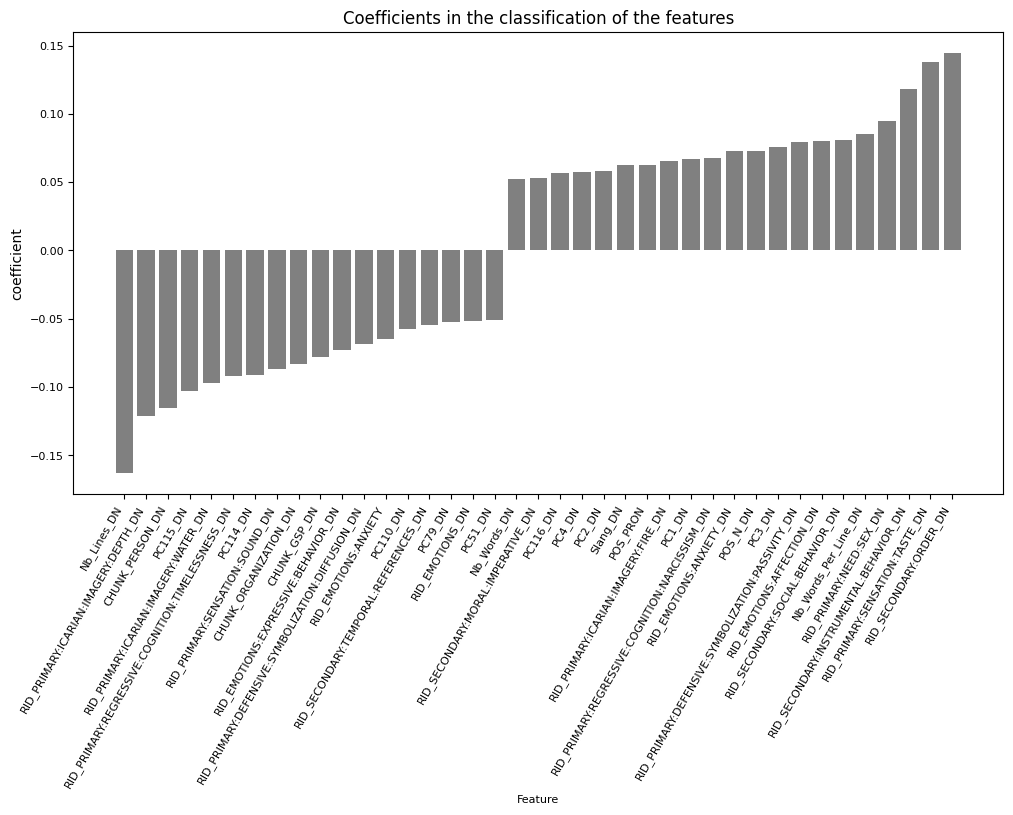

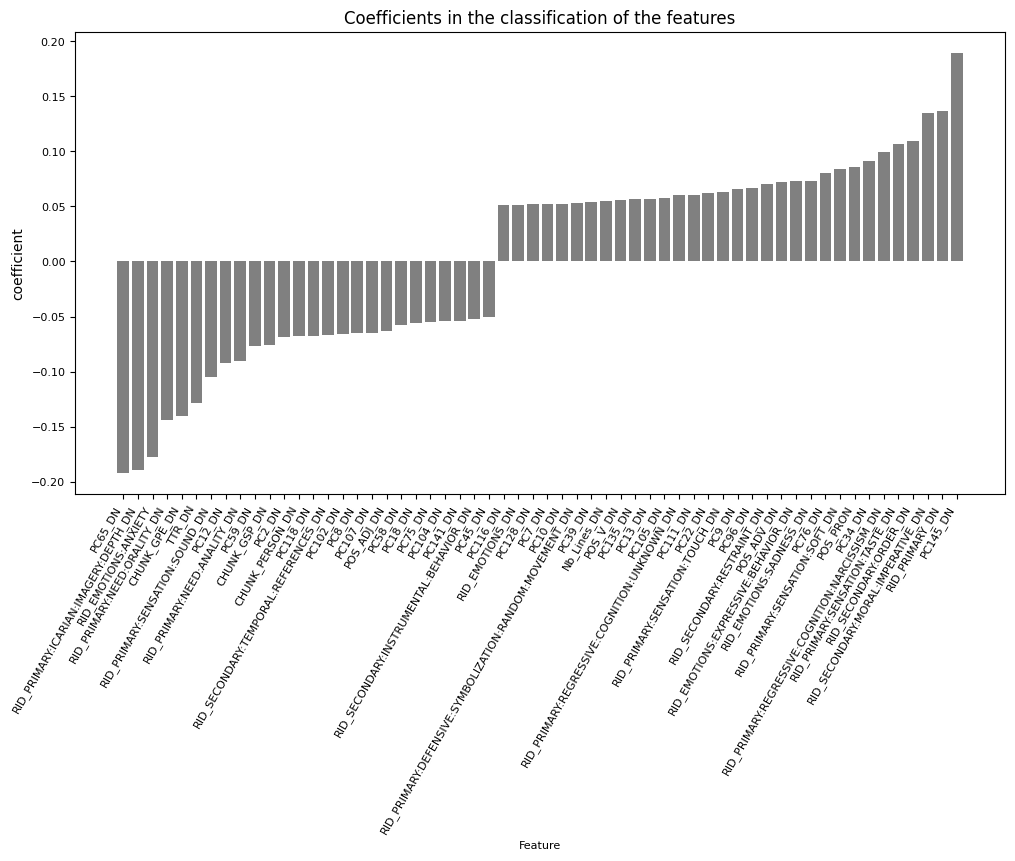

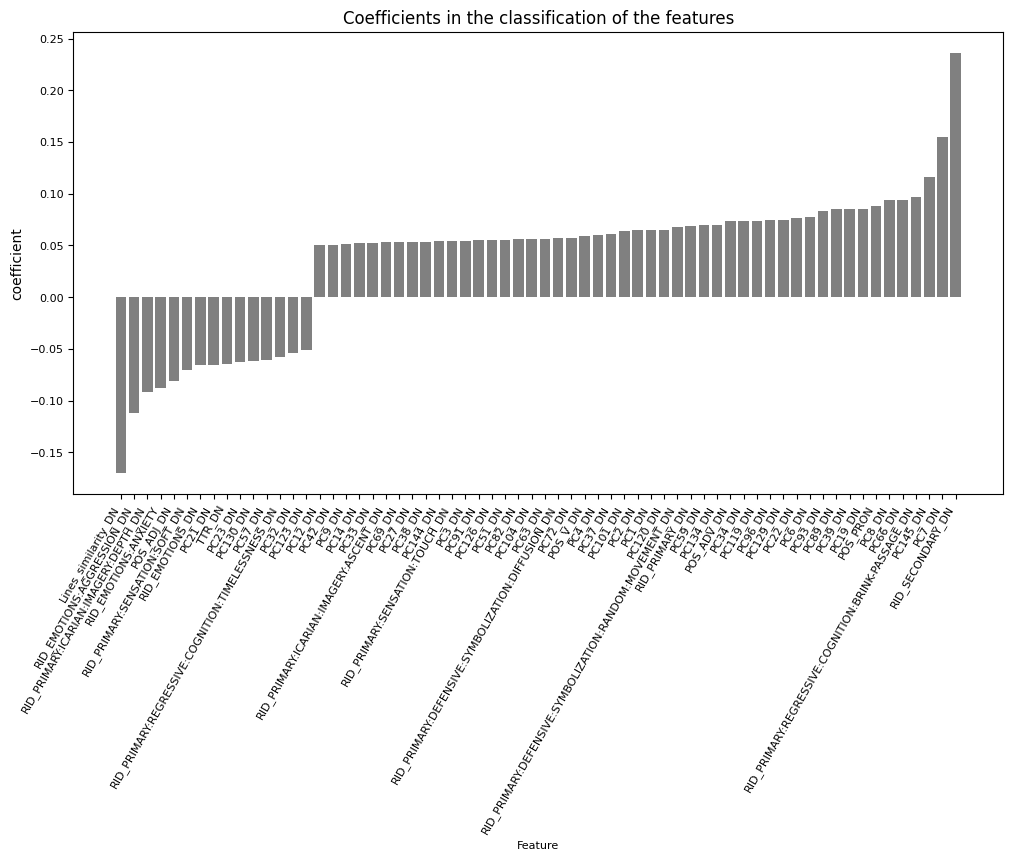

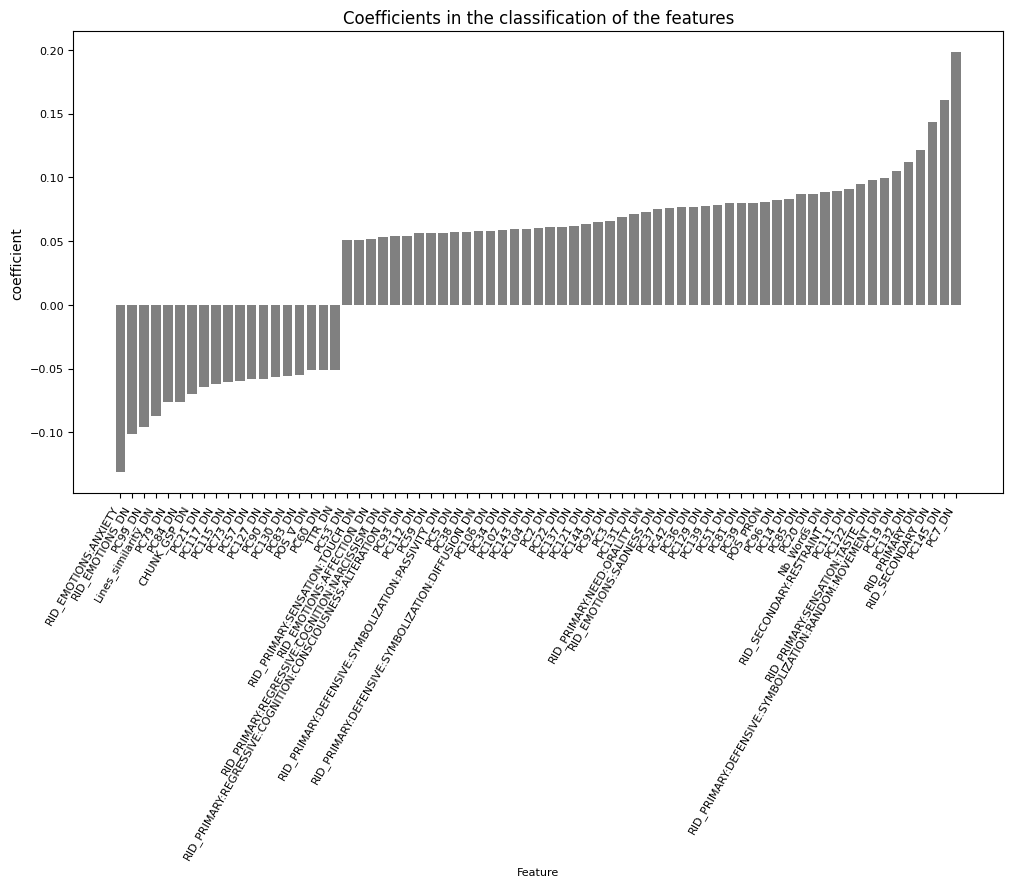

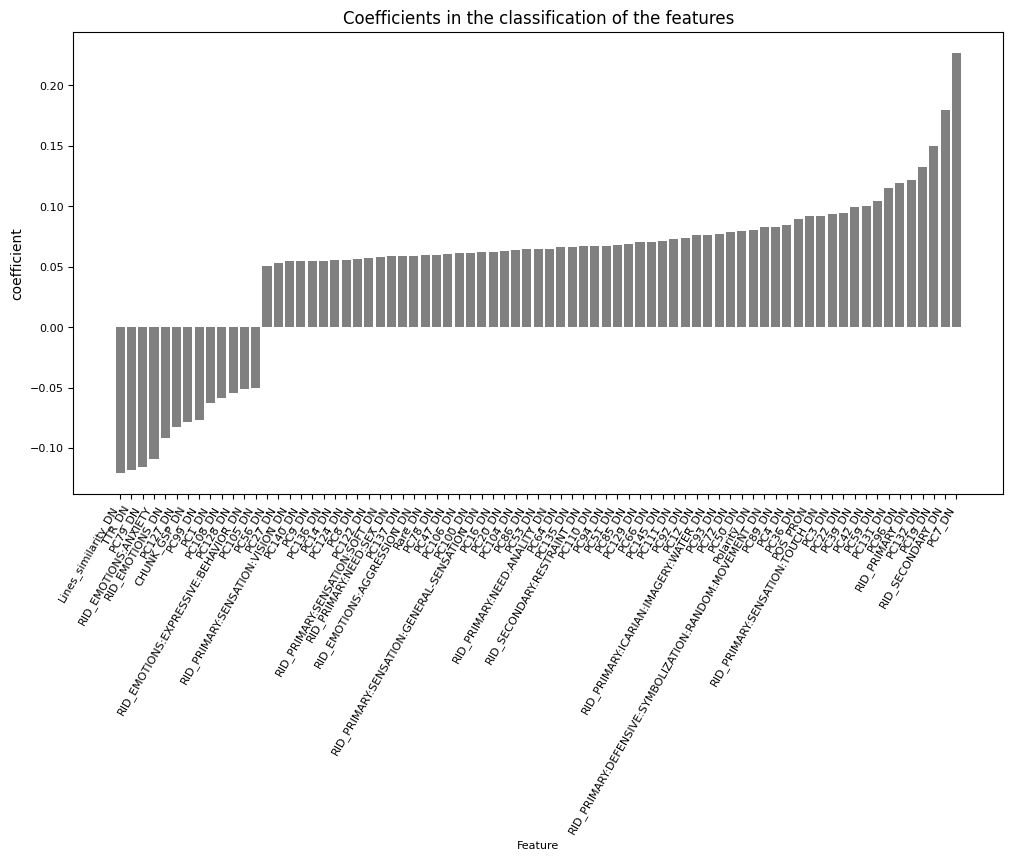

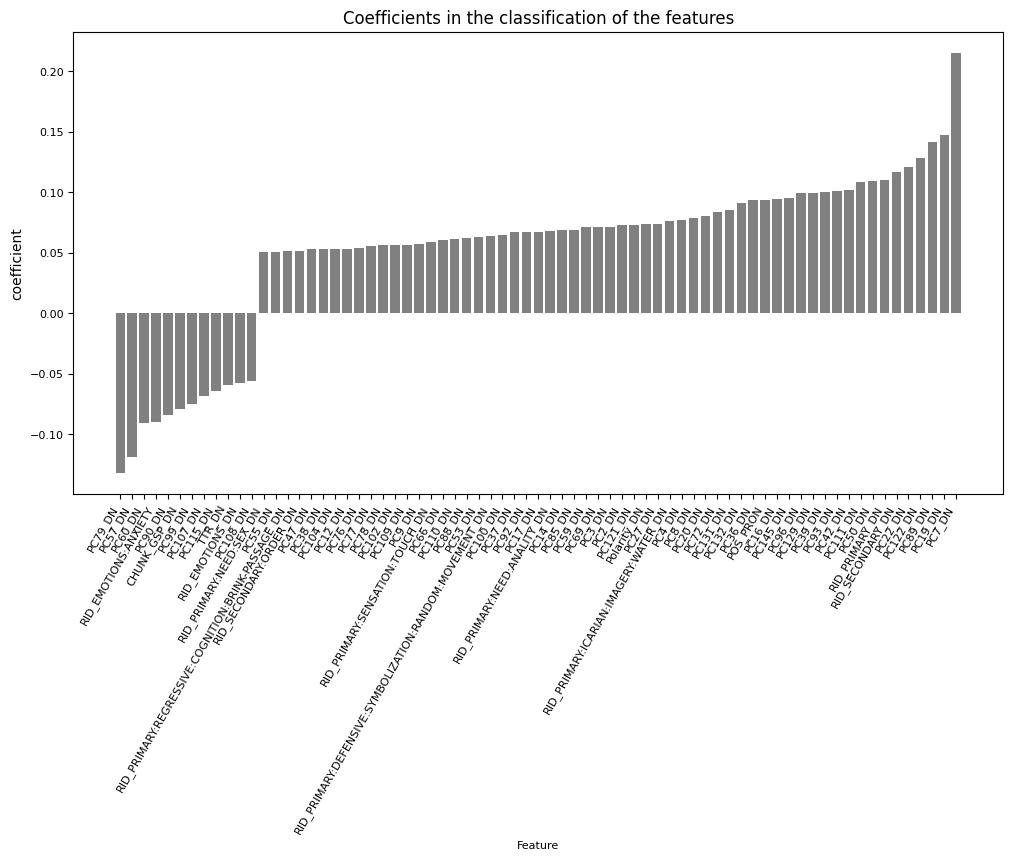

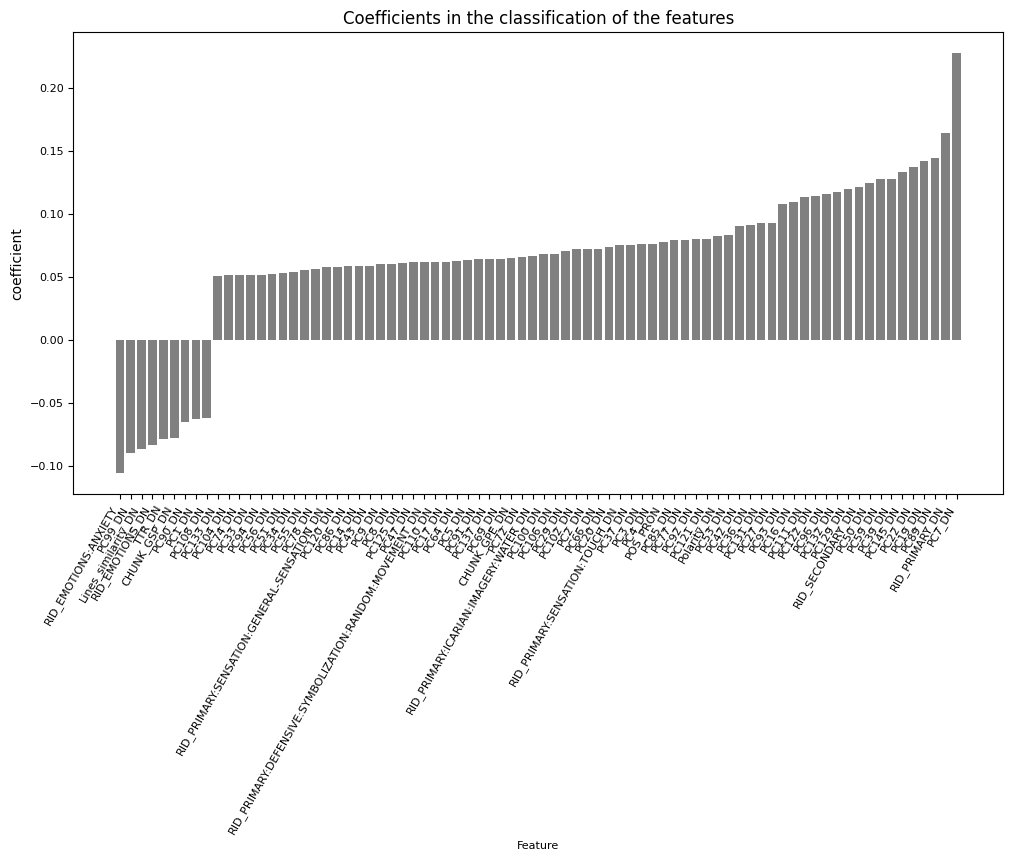

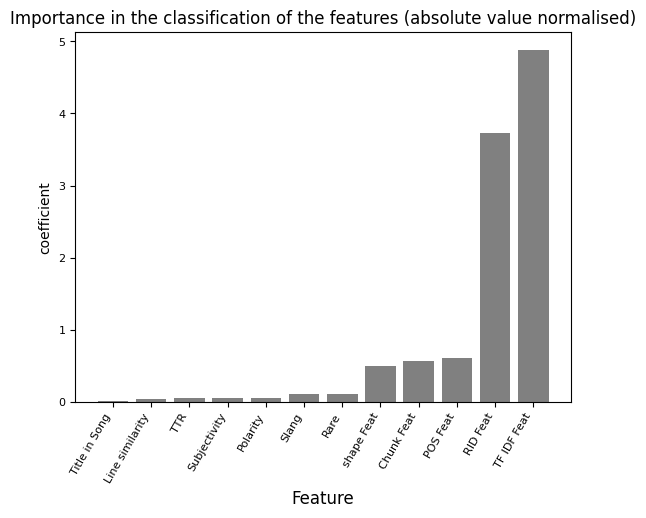

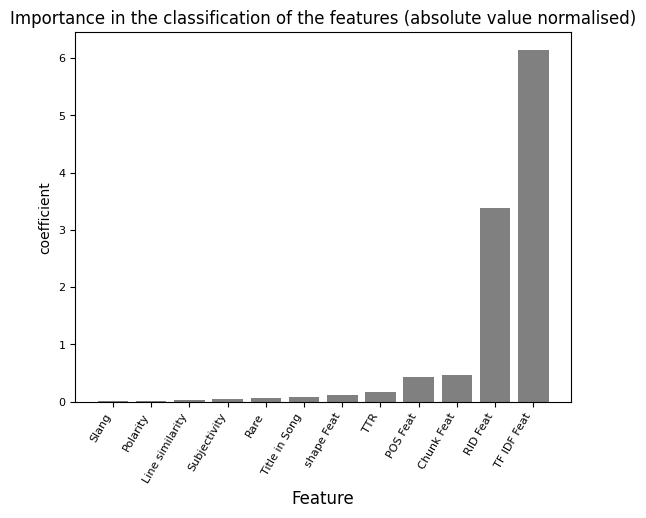

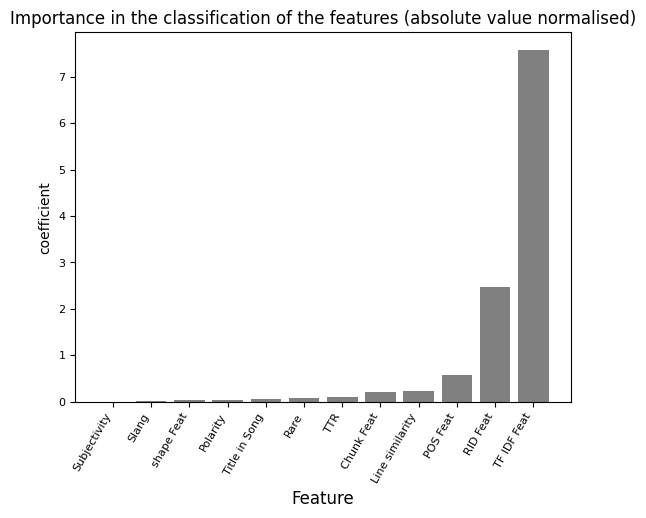

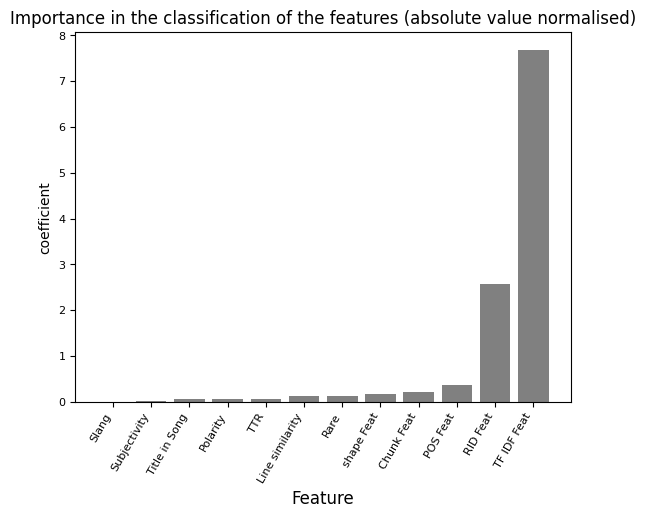

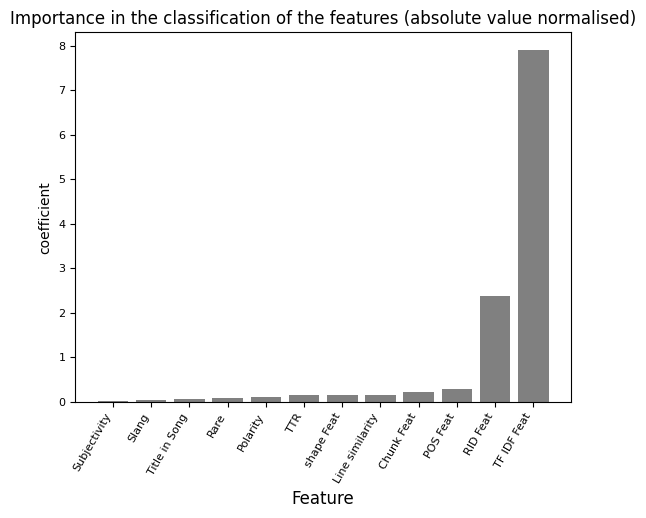

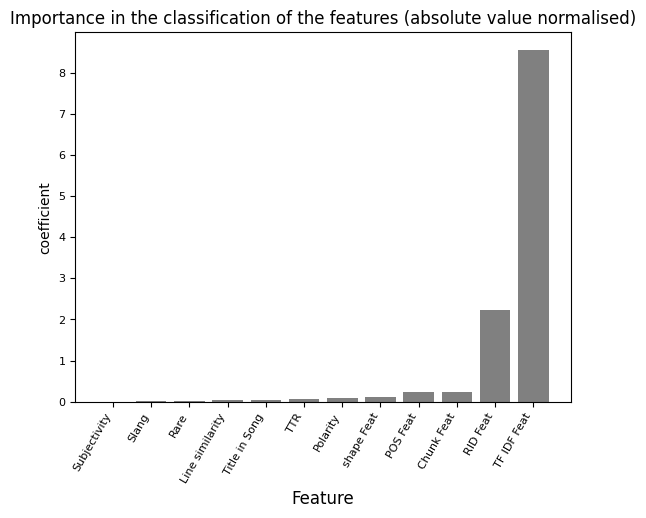

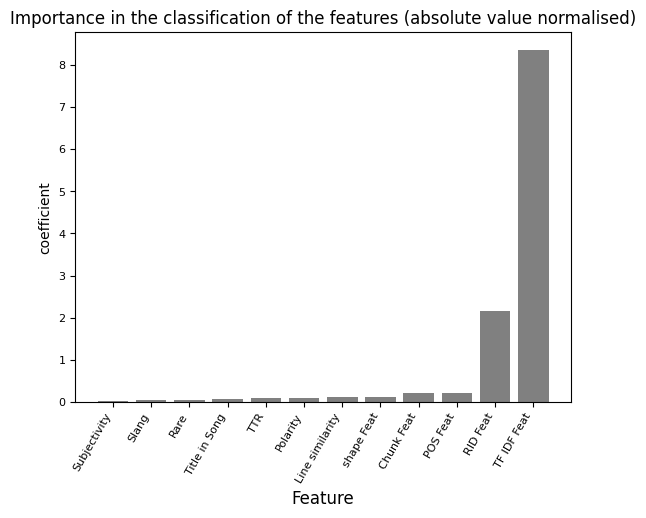

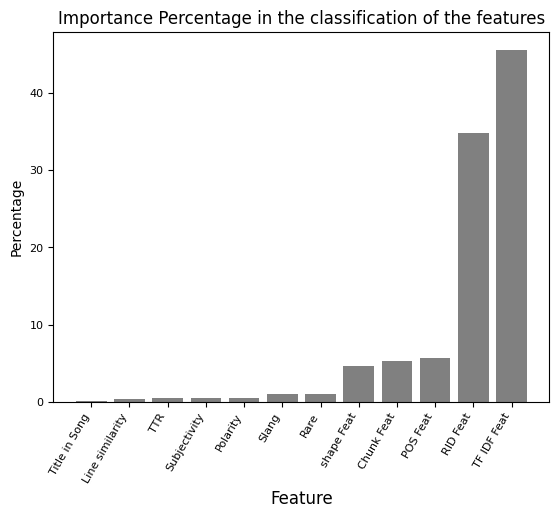

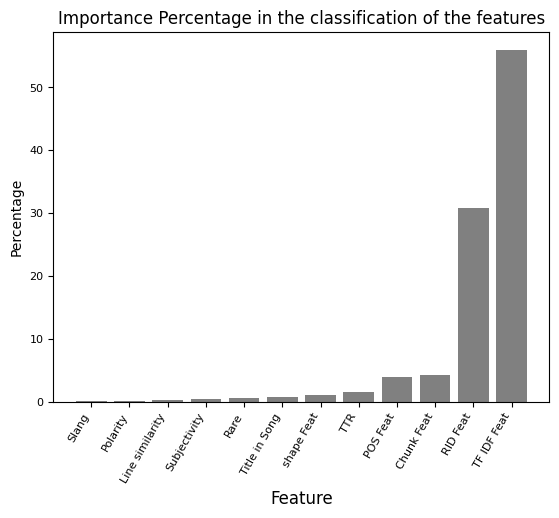

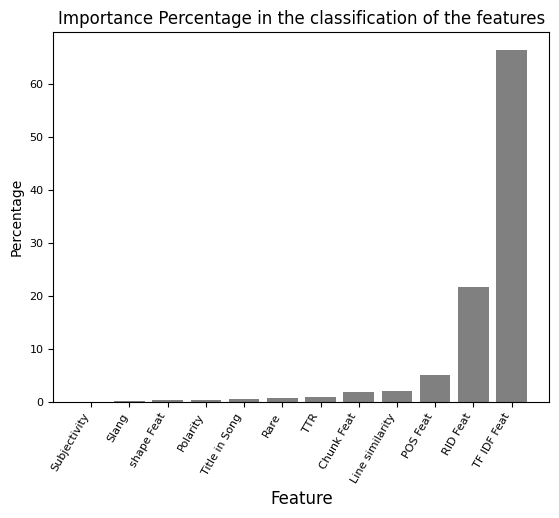

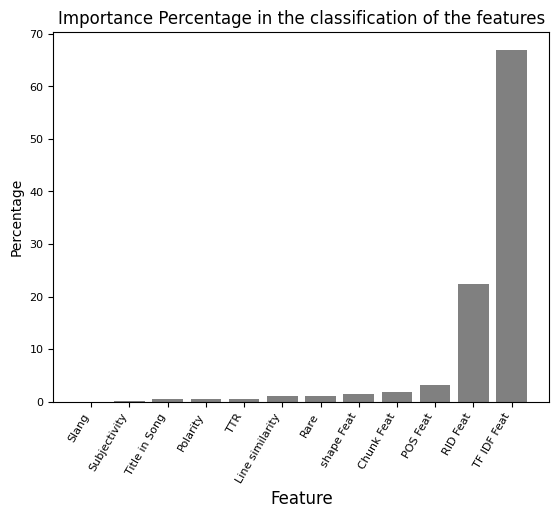

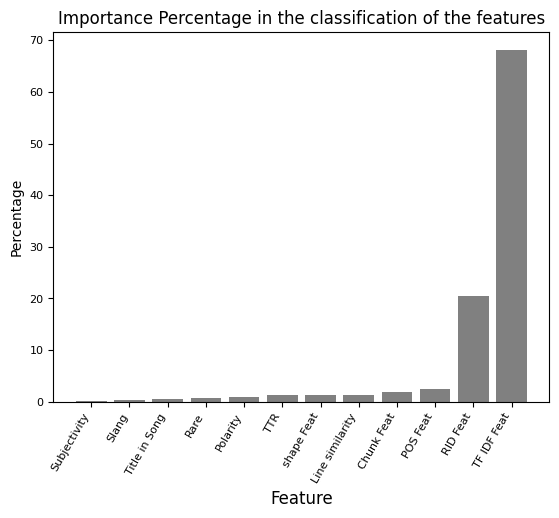

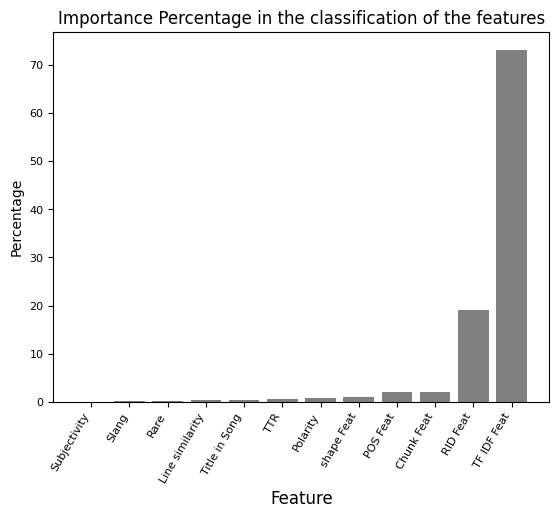

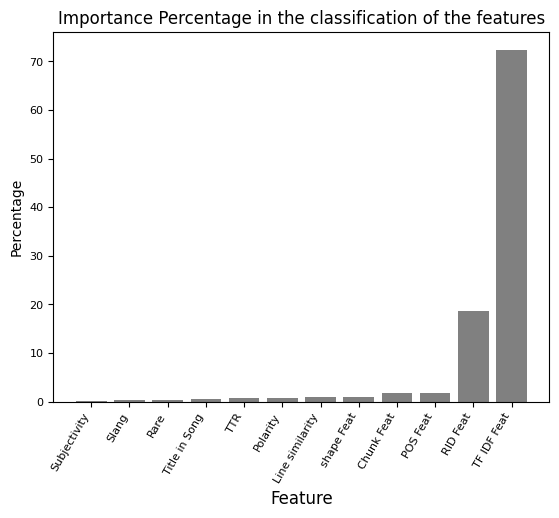

In [23]:
feature_imp1(crr, fts)
feature_imp2(crr, fts)
feature_imp3(crr, fts)

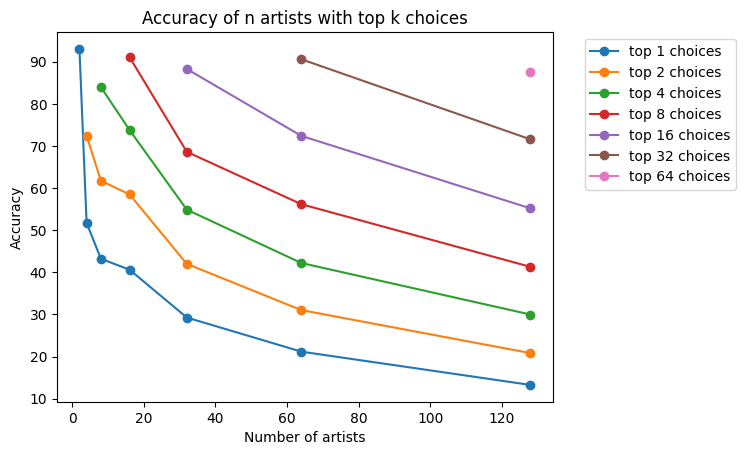

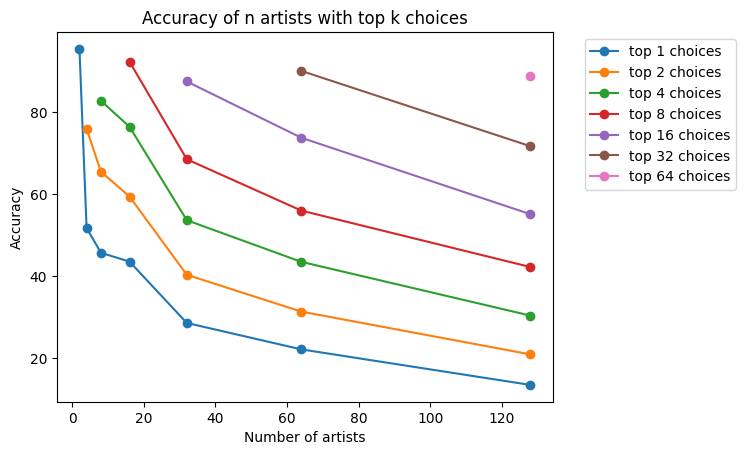

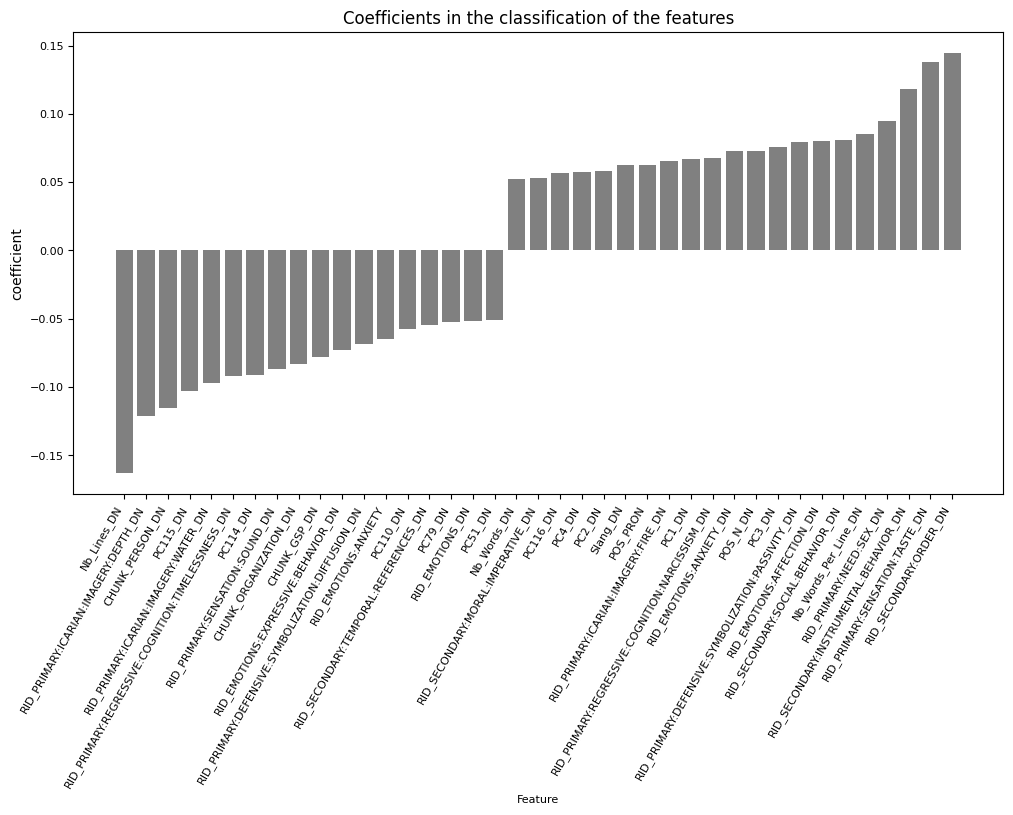

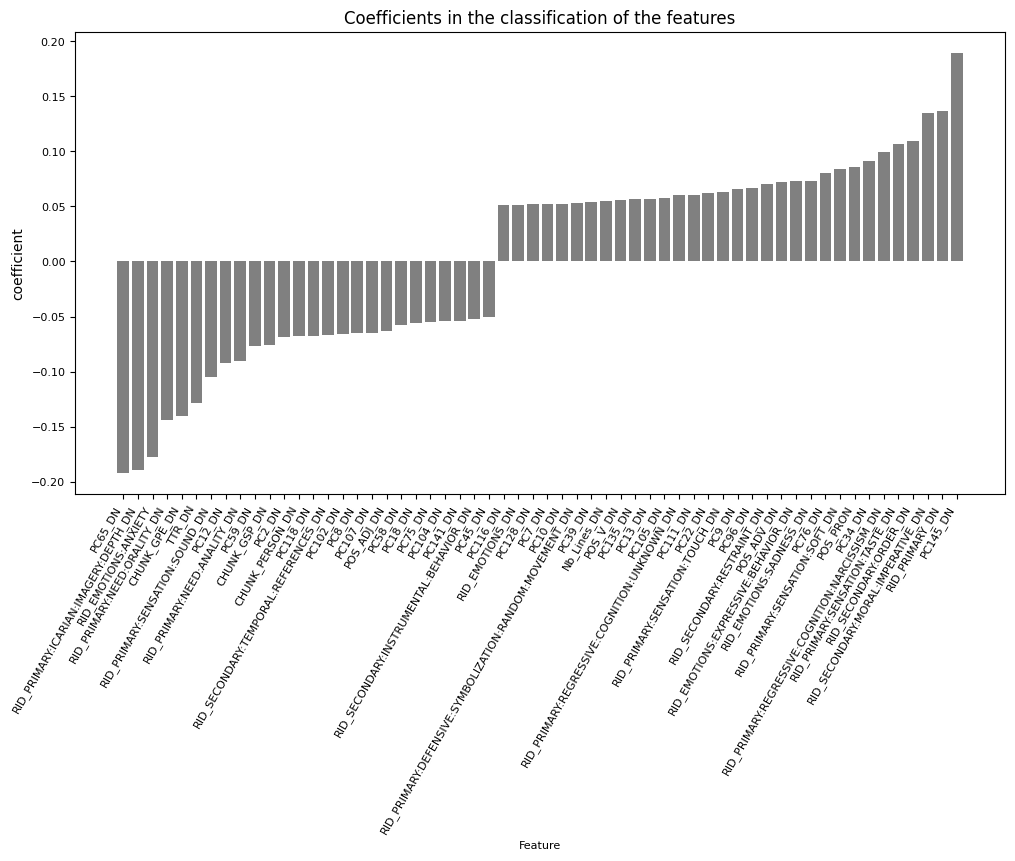

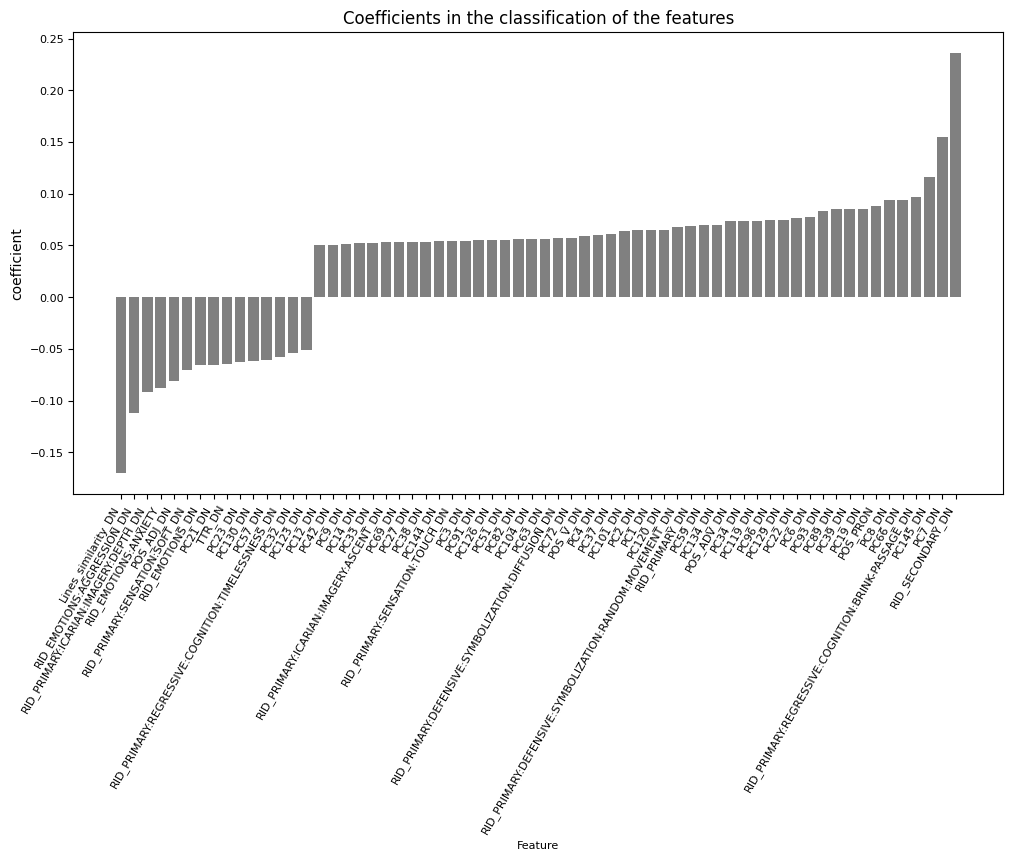

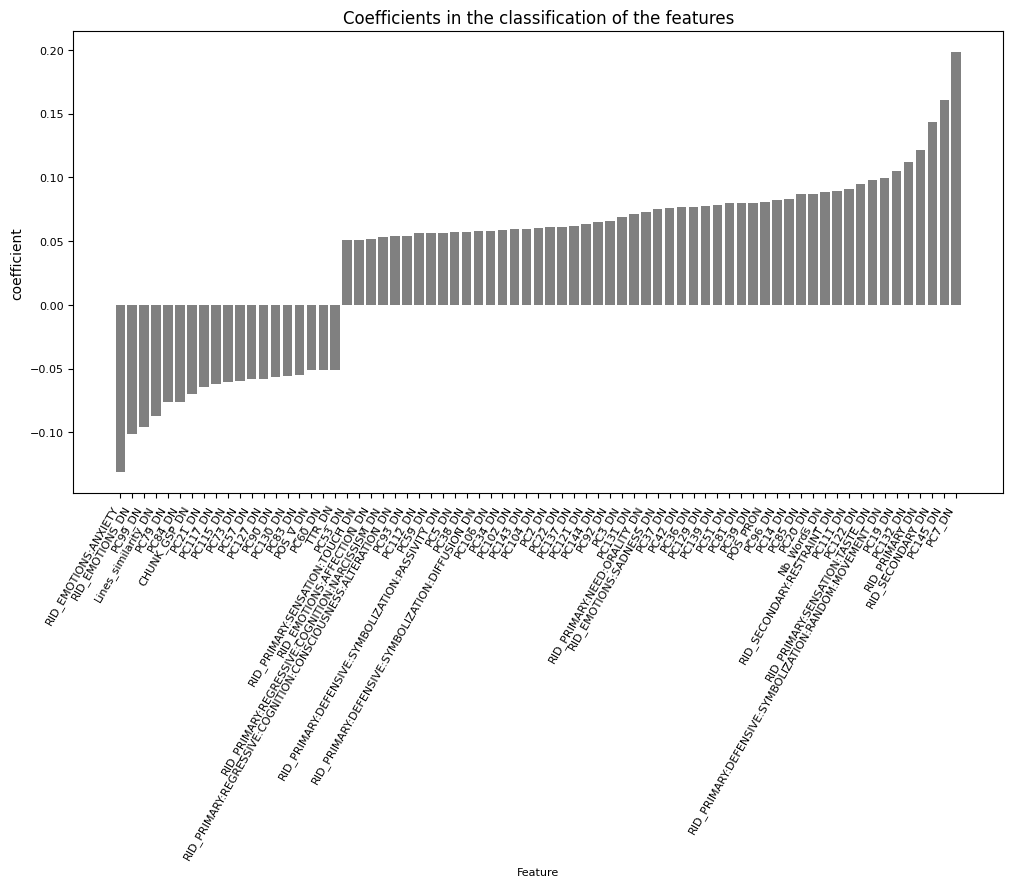

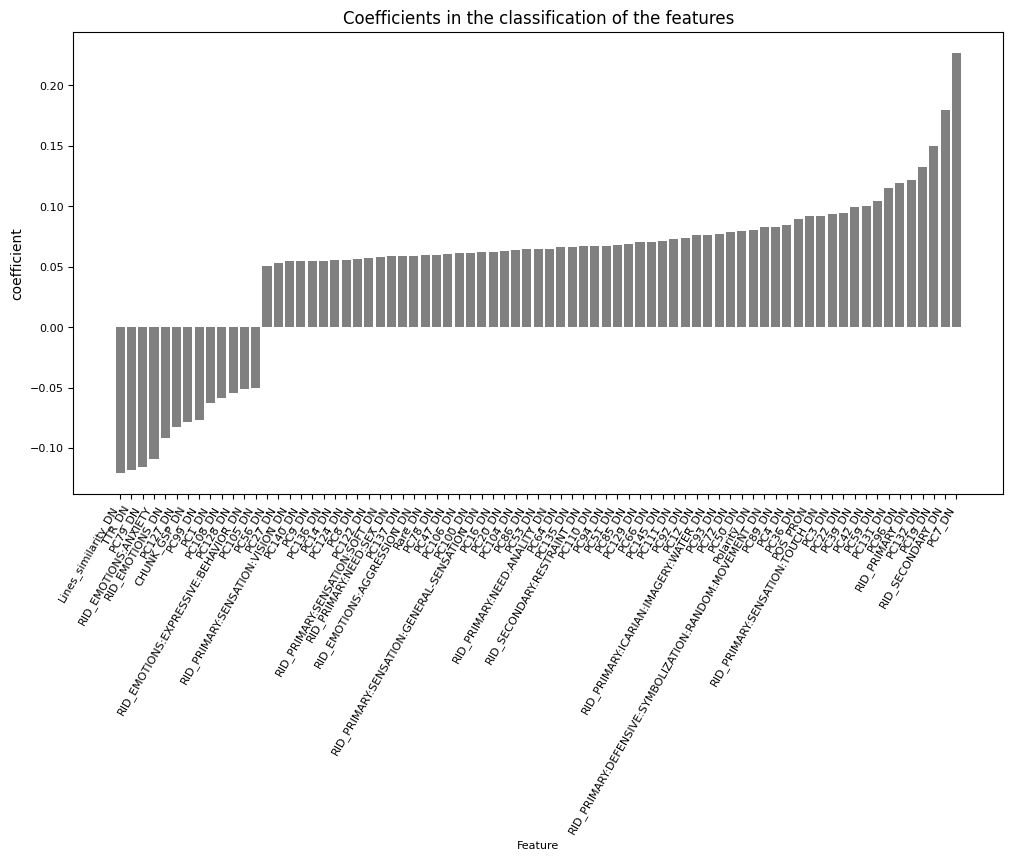

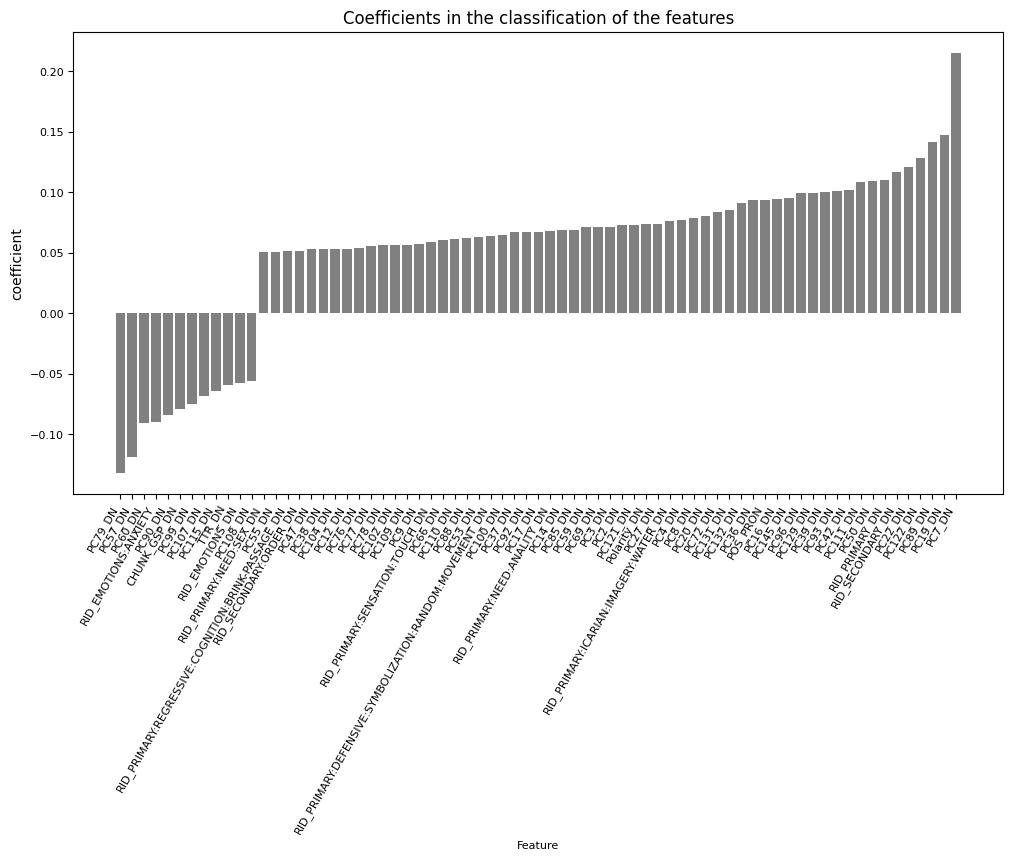

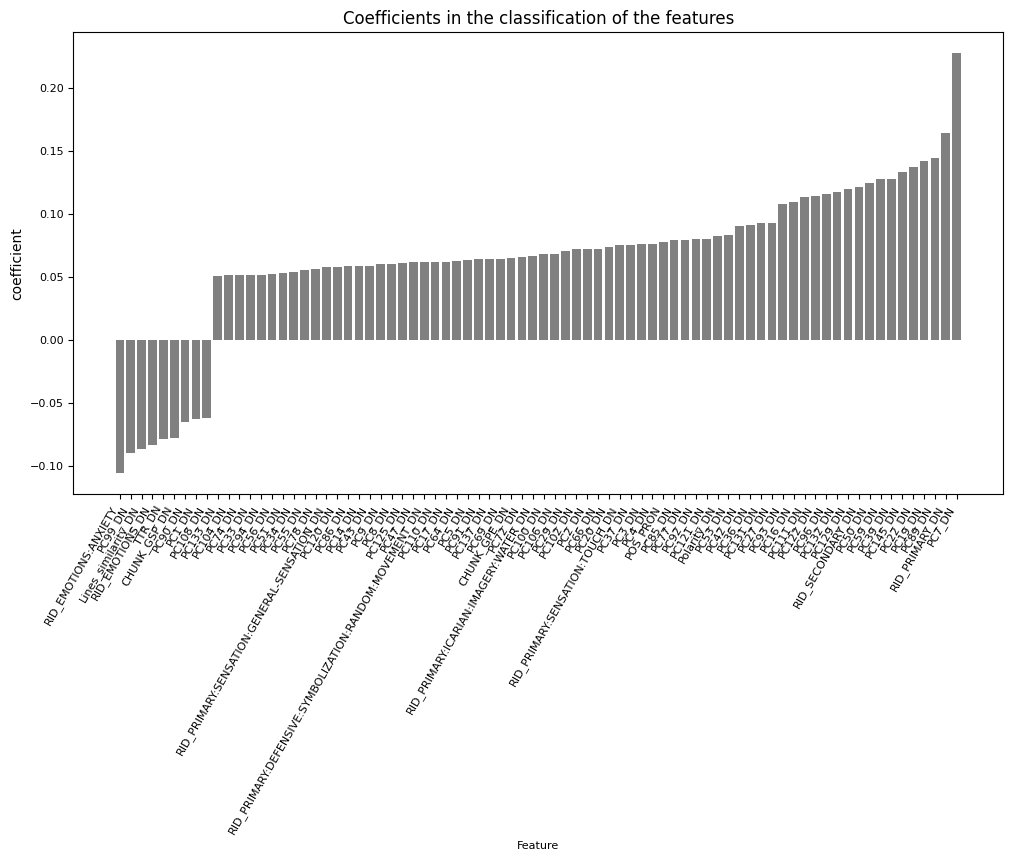

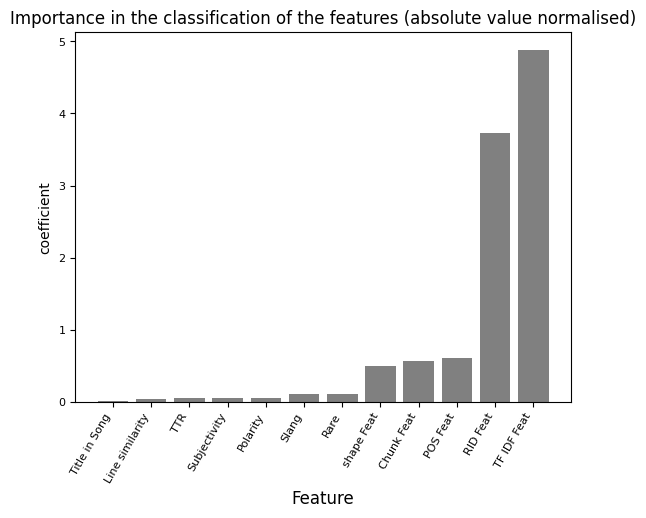

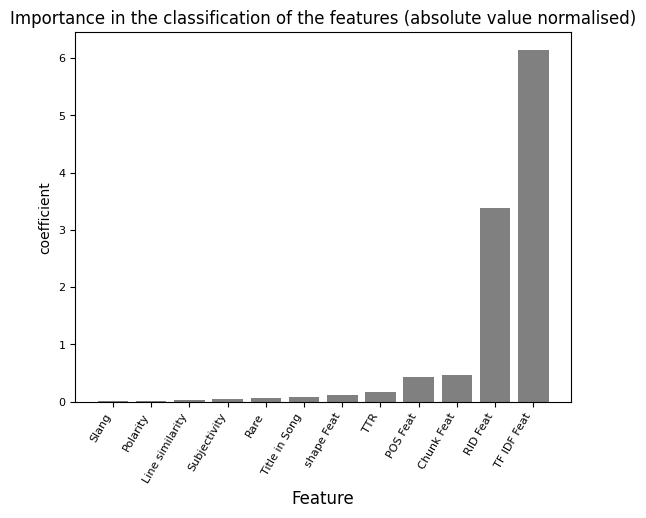

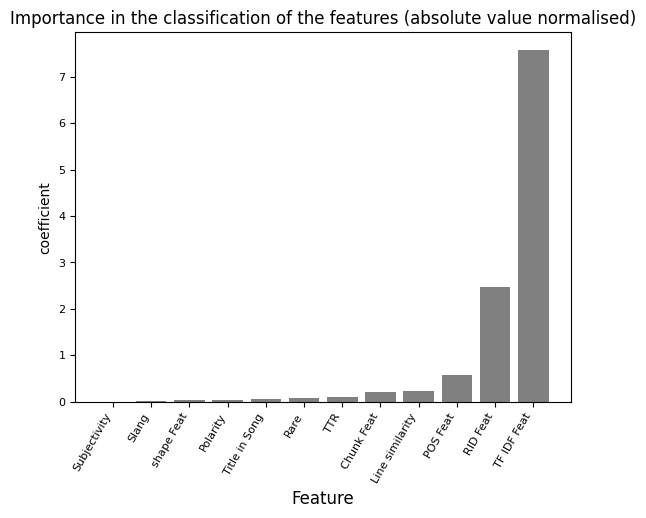

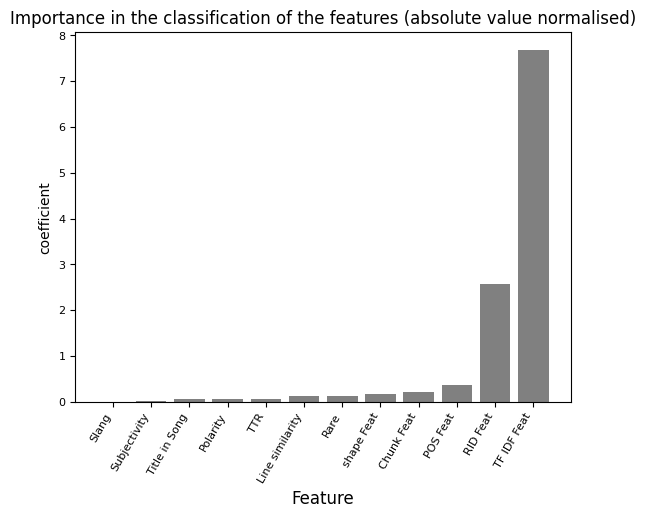

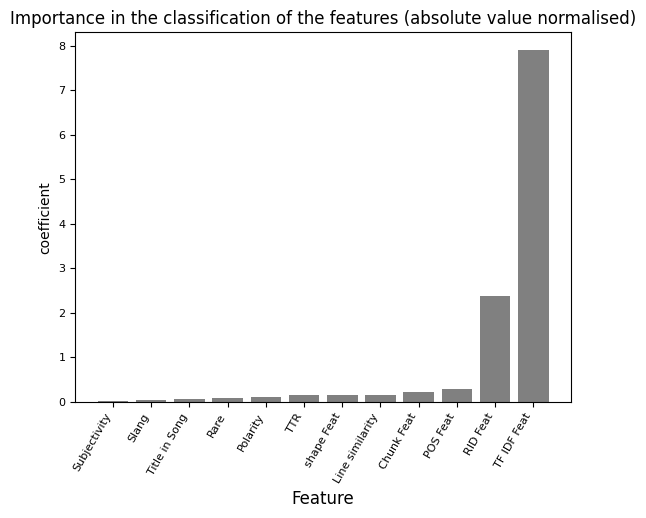

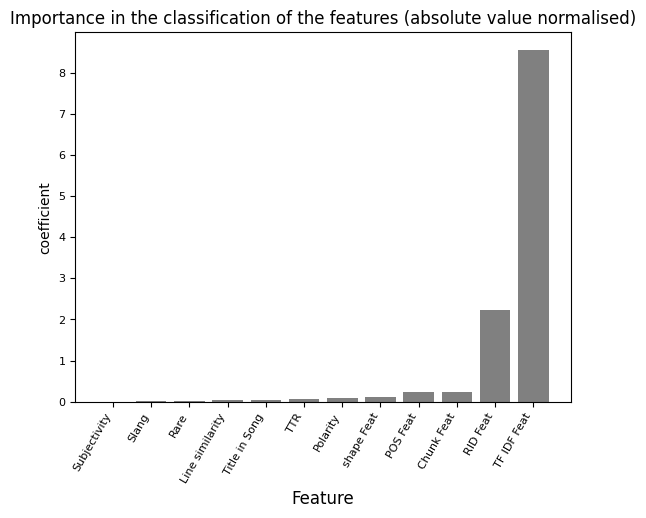

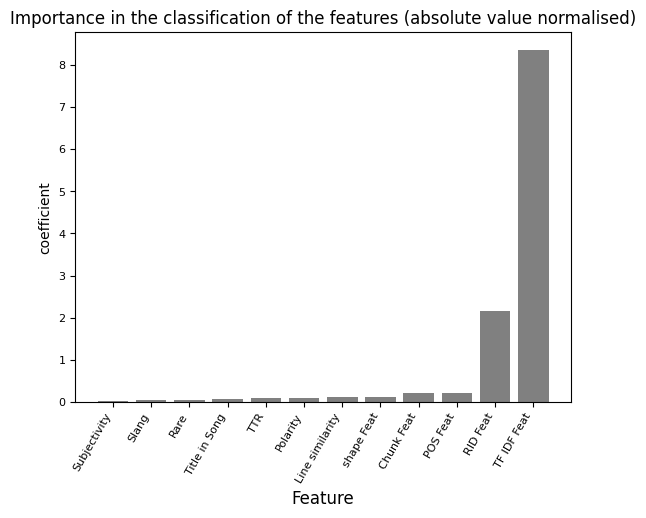

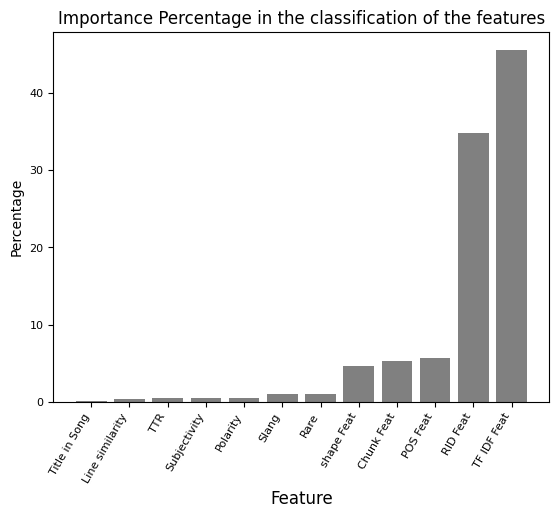

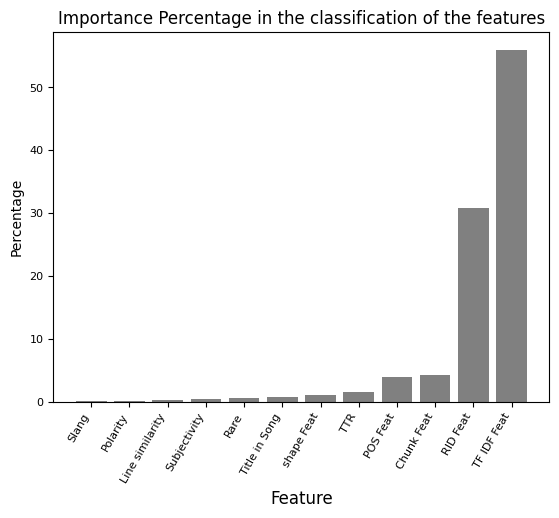

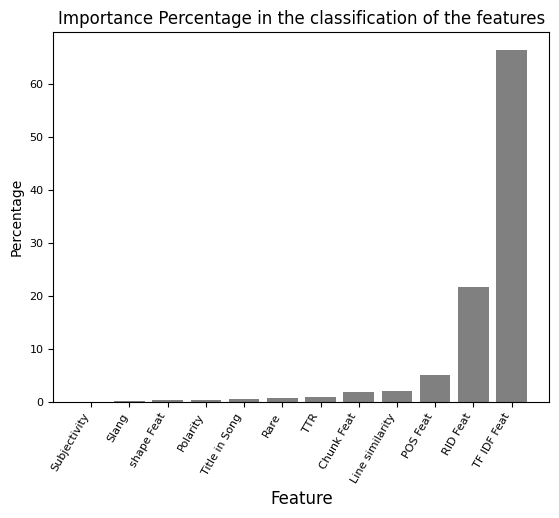

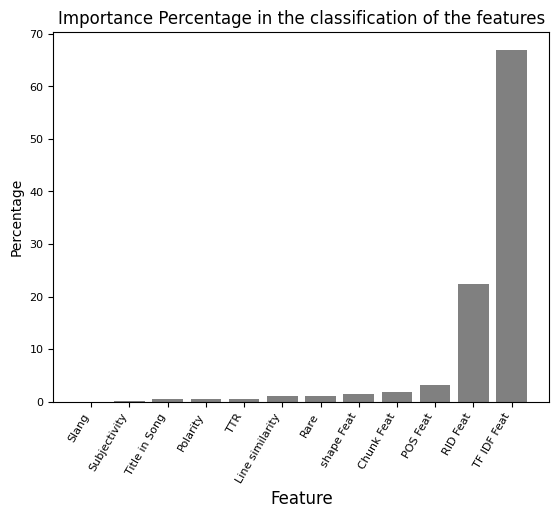

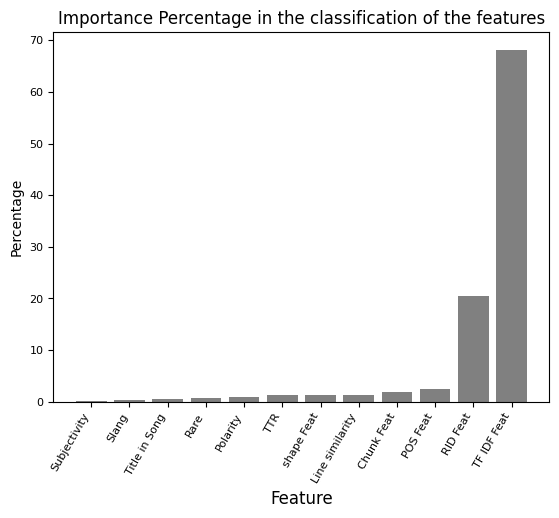

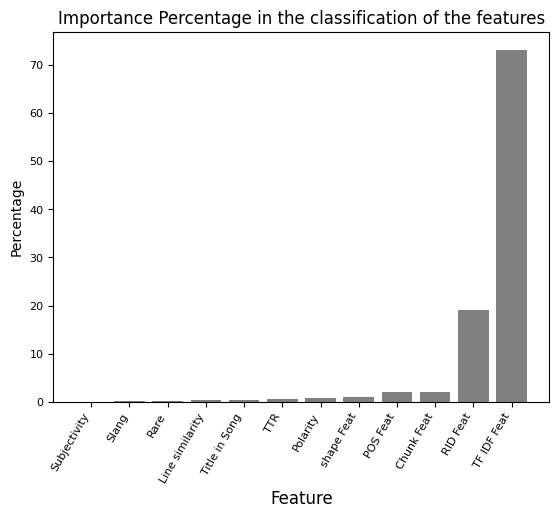

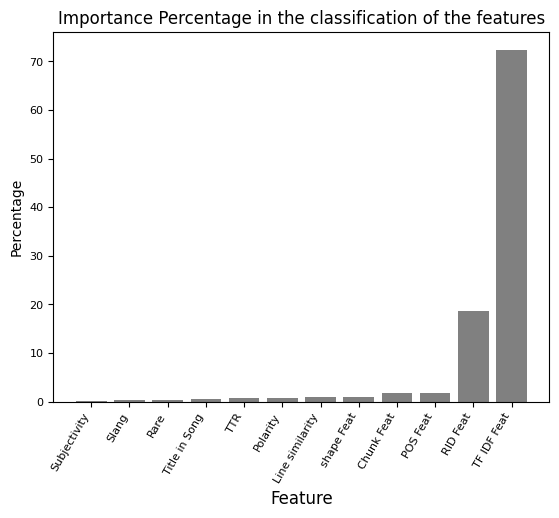

In [24]:
plot_top_tog(brr = brr, nlist = nlist, top = top)
plot_top_tog(brr = brrlog, nlist =nlist, top = top)
feature_imp1(crr=crr, fts = fts)
feature_imp2(crr=crr, fts = fts)
feature_imp3(crr=crr, fts = fts)